# Цель проекта
***
### Приоритизация гипотез, запуск A/B-теста и анализ результатов
***

# [Содержание]()

## [Описание исходных данных](#0)
  
## [Часть 1. EDA](#1)
* [1.1. Общая информация](#11)
* [1.2. Преобразование типов данных](#12)
* [1.3. Проверка на пропуски](#13)
* [1.4. Проверка на очевидные дубликаты](#14)
* [Вывод](#15)

## [Часть 2. Приоритизация гипотез](#2)
* [2.1. Применение фреймворка ICE для приоритизации гипотез](#21)  
* [2.2. Применение фреймворка RICE для приоритизации гипотез](#22)
* [Вывод](#23)  

## [Часть 3. Анализ A/B-теста](#3)
* [3.1. Графики кумулятивных метрик](#31)  
* [3.2. Применение фреймворка RICE для приоритизации гипотез](#32)
* [3.3. Применение фреймворка RICE для приоритизации гипотез](#34)
* [Вывод](#34)  

## [Вывод](#4)

***Импортируем необходимые библиотеки***

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 7)})

## Описание исходных данных <a name="0"></a>

### Данные для первой части:  

**Файл /datasets/hypothesis.csv:**
* Hypothesis — краткое описание гипотезы
* Reach — охват пользователей по 10-балльной шкале
* Impact — влияние на пользователей по 10-балльной шкале
* Confidence — уверенность в гипотезе по 10-балльной шкале
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы    

### Данные для второй части:  

**Файл /datasets/orders.csv:**  
* transactionId — идентификатор заказа
* visitorId — идентификатор пользователя, совершившего заказ
* date — дата, когда был совершён заказ
* revenue — выручка заказа 
* group — группа A/B-теста, в которую попал заказ  

**Файл /datasets/visitors.csv:**
* date — дата
* group — группа A/B-теста
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# 1. EDA <a name="1"></a>

***Импортируем таблицы***

In [2]:
hyp = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visits = pd.read_csv('/datasets/visitors.csv')

### 1.1. Посмотрим общую информацию о датафреймах <a name="11"></a>

In [3]:
hyp.info()
orders.info()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


***Приведем к нормальному виду названия столбцов***

In [4]:
hyp.columns = [col.lower().replace(' ','_') for col in hyp.columns]
orders.columns = [col.lower().replace(' ','_') for col in orders.columns]
visits.columns = [col.lower().replace(' ','_') for col in visits.columns]

***Посмотрим на значение внутри таблиц***

In [5]:
hyp.sample(3)

,hypothesis,reach,impact,confidence,efforts
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


In [6]:
orders.sample(3)

,transactionid,visitorid,date,revenue,group
386,1802431162,3127757912,2019-08-03,20990,A
496,2825038272,3951559397,2019-08-29,30990,B
638,2184241291,2399568665,2019-08-09,3040,B


In [7]:
visits.sample(3)

,date,group,visitors
44,2019-08-14,B,746
15,2019-08-16,A,361
11,2019-08-12,A,595


***Уберем пробелы из столбца с гипотезами***

In [8]:
hyp['hypothesis'] = hyp['hypothesis'].map(lambda x: x.strip())

***Проверим есть ли пользователи,попавшие в обе группы***

In [9]:
groupA = orders[['visitorid','group']].query('group == "A"')
groupB = orders[['visitorid','group']].query('group == "B"')
broken = groupA.merge(groupB, how='inner', on='visitorid')
broken_users = broken['visitorid'].unique()
broken_users

array([4069496402,  199603092, 3803269165, 2378935119,  237748145,
       4256040402, 2038680547, 1738359350, 2458001652, 3891541246,
       2716752286, 3656415546, 2686716486, 2954449915, 2927087541,
       3234906277,  457167155, 2579882178, 3957174400, 1648269707,
       2780786433,  818047933, 2044997962, 1959144690, 3202540741,
       1333886533,  351125977, 3951559397,  393266494, 3984495233,
       4120364173, 4266935830, 1230306981, 1294878855, 1614305549,
          8300375,  477780734, 1668030113, 3717692402, 3766097110,
       3941795274,  471551937, 1316129916, 1801183820, 1602967004,
       2587333274, 2600415354,  232979603, 3972127743, 1404934699,
        276558944, 3062433592, 2654030115, 3963646447, 4186807279,
       2712142231, 2949041841,  963407295])

***Посчитаем выручку, которую принесли сломанные юзеры***

In [10]:
orders.query('visitorid in @broken_users')['revenue'].sum() / orders.query('visitorid not in @broken_users')['revenue'].sum()

0.18484749386622223

***Почти 18.5% от выручки за весь экспиримент, это может существенно исказить результат, придется избавиться***

In [11]:
orders = orders.query('visitorid not in @broken_users')

### 1.2. Преобразуем типы данных к рабочим  <a name="12"></a>

In [12]:
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visits['date'] = pd.to_datetime(visits['date'], format = '%Y-%m-%d')        

### 1.3. Проверим наличие очевидных пропусков  <a name="13"></a>

In [13]:
hyp.isna().sum()
orders.isna().sum()
visits.isna().sum()

date        0
group       0
visitors    0
dtype: int64

### 1.4. Проверим наличие очевидных дубликатов <a name="14"></a>

In [14]:
hyp.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
visits.duplicated().sum()

0

### Вывод   <a name="15"></a>

* ***Привели названия столбцов в нормальный вид***
* ***Скорректировали типы данных***
* ***Не выявлено очевидных пропусков***
* ***Не выявлено очевидных дубликатов*** 

# 2. Приоритизация гипотез <a name="2"></a>

### 2.1. Применение фреймворка ICE для приоритизации гипотез <a name="21"></a>  


  
<div class="alert alert-block alert-warning">
    <br>
$$ICE = \frac{Impact * Confidence}{Efforts}$$
    </div>

***Поместим параметр ICE в новый столбец***

In [17]:
hyp['ice'] = (hyp['impact'] + hyp['confidence']) / hyp['efforts']

***Отсортируем гипотезы по параметру ICE***

In [18]:
pd.options.display.max_colwidth = 150
hyp.sort_values('ice',ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,3.666667
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,3.600000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,3.333333
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,3.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,3.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,0.900000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,0.750000


### 2.2. Применение фреймворка RICE для приоритизации гипотез <a name="22"></a>

<div class="alert alert-block alert-warning">
    <br>
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
    </div>

***Поместим параметр RICE в новый столбец***

In [19]:
hyp['rice'] = (hyp['confidence'] + hyp['impact'] + hyp['confidence']) / hyp['efforts']

***Отсортируем гипотезы по параметру RICE***

In [20]:
hyp.sort_values('rice',ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,3.666667,6.333333
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,3.333333,5.666667
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,3.600000,5.400000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,3.000000,4.600000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,3.000000,4.333333
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,2.000000,3.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,2.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,0.900000,1.300000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,0.750000,1.125000


### Вывод <a name="23"></a>

На данных гипотезах методы приоритезации ICE и RICE работают практически идентично, поменялись местаами только гипотезы 8 и 2 (топ-3 и топ-2 по приоритетам), так как параметр reach (охват аудитории) между ними отличается в восемь раз.  
На решение какому из методов довериться может повлиять специфика бизнеса.

# 3. Анализ A/B-теста <a name="3"></a>

### 3.1. Построим графики  <a name="31"></a>
* Кумулятивной выручки по группам;
* Кумулятивного среднего чека по группам;
* Относительного изменения кумулятивного среднего чека группы B к группе A;
* Кумулятивной конверсии по группам;
* Относительного изменения кумулятивной конверсии группы B к группе A.

***Сохраним в переменную таблицу с всеми днями тестирования для каждой группы***

In [21]:
datesGroups = orders[['date','group']].drop_duplicates()

***Сохраним в переменную таблицу с количеством уникальных посетителей, уникальных сделок, и суммой выручки к определенному дню по каждой из групп***

In [22]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitorid' : pd.Series.nunique,
      'transactionid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
ordersAggregated.head(4)

,date,group,visitorid,transactionid,revenue
55,2019-08-01,A,19,23,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,36,42,234381
173,2019-08-02,B,39,40,221801


***Сохраним в переменную таблицу с количеством посещений пользователей каждой из групп к определенному дню***

In [23]:
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(
    visits['date'] <= x['date'], visits['group'] == x['group'])].agg(
    {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 
visitorsAggregated.head(4)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294


***Объединим полученные таблицы***

In [24]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.reset_index().head(4)

,index,date,group,orders,buyers,revenue,visitors
0,0,2019-08-01,A,19,23,142779,719
1,1,2019-08-01,B,17,17,59758,713
2,2,2019-08-02,A,36,42,234381,1338
3,3,2019-08-02,B,39,40,221801,1294


**Построим график кумулятивной выручки по группам**

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


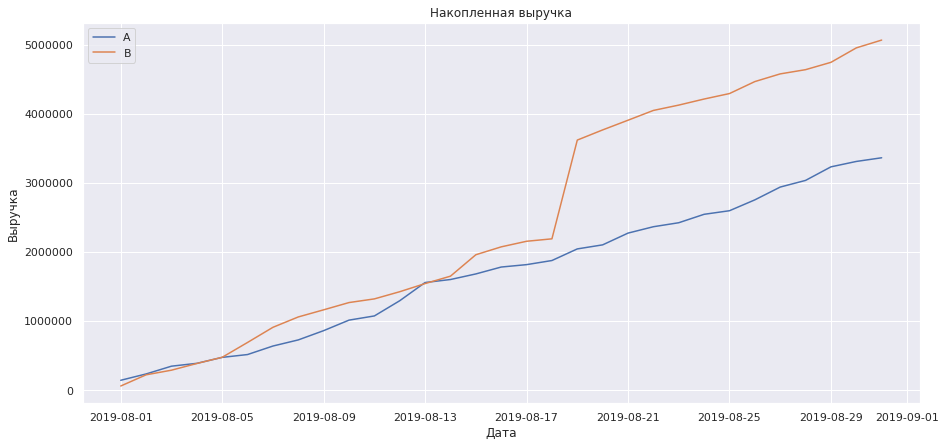

In [25]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.title("Накопленная выручка")
plt.legend()
plt.show()

***Группа B резко стала граздо прибыльнее 18.09.2019, похоже, что на картинку сильно влияет выброс***

**Построим график кумулятивного среднего чека по группам**

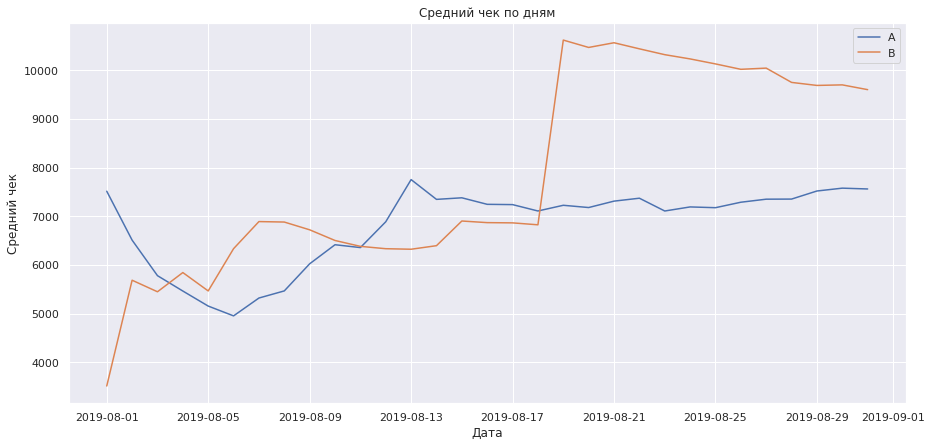

In [26]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.title("Средний чек по дням")
plt.legend()

***Определенно данные искажены большим заказом***

**Построим график относительного изменения кумулятивного среднего чека группы B к группе A**

***Сохраним данные по кумулятивной выручке в один датафрейм***

In [27]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

Text(0.5, 1.0, 'Оносительное изменение кумулятивного среднего чека группы B к группе A')

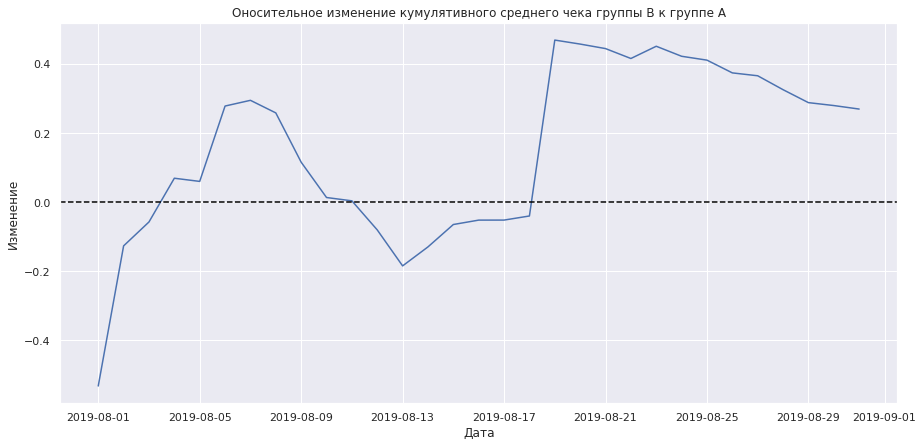

In [28]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Изменение")
plt.title("Оносительное изменение кумулятивного среднего чека группы B к группе A")

***Сильные колебания в начале, с 24.08.2019 наблюдается спад***

**Построим график кумулятивной конверсии по группам**

***Рассчитаем кумулятивную конверсию***

In [29]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

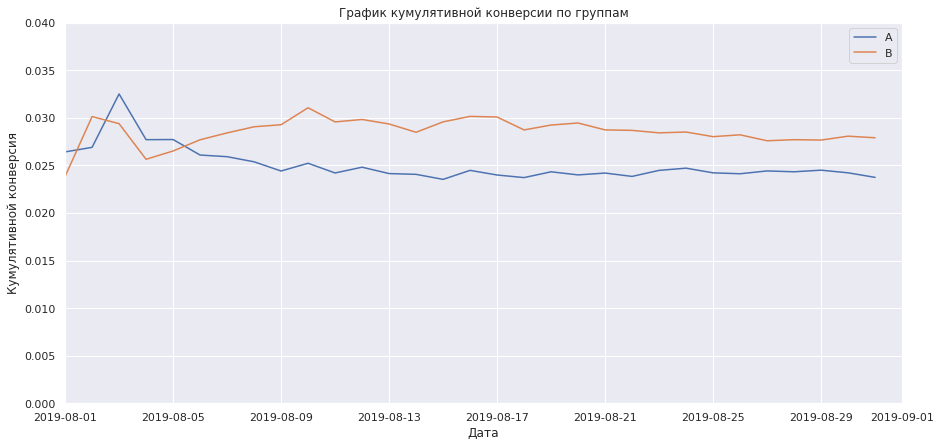

In [30]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel("Дата")
plt.ylabel("Кумулятивной конверсия")
plt.title("График кумулятивной конверсии по группам")
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0, 0.04])
plt.show()

***Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась***

**Построим график относительного различия кумулятивных конверсий**

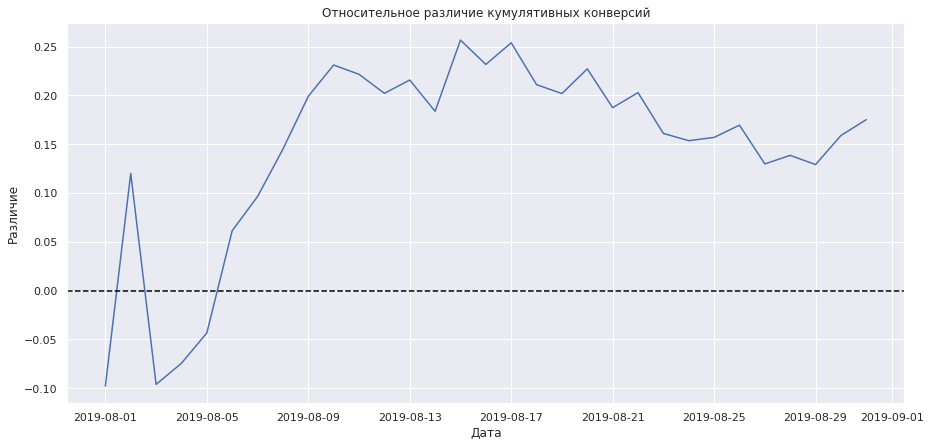

In [31]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xlabel("Дата")
plt.ylabel("Различие")
plt.title("Относительное различие кумулятивных конверсий")

plt.axhline(y=0, color='black', linestyle='--')

***В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя***

***В основном каждый делает по заказу, 2 заказа встречается не часто, а 3 практически не бывает***

### 3.2. Проанализируем количество и сумму заказов <a name="32"></a>

**Построим точечный график количества заказов по пользователям**

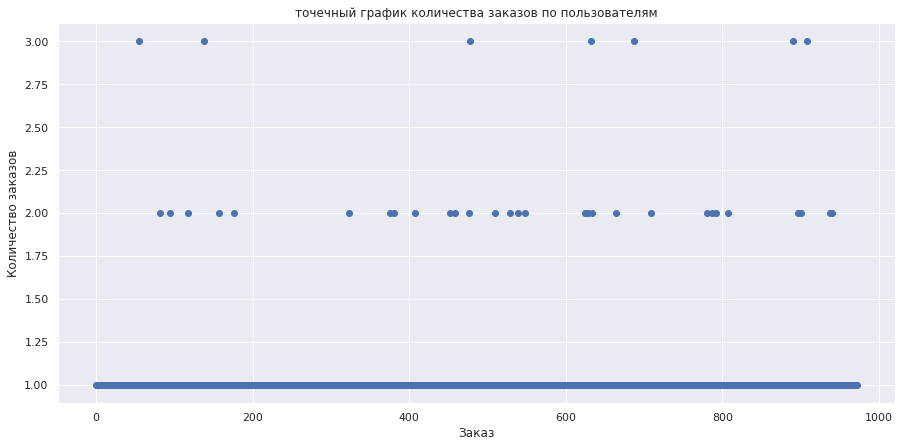

In [32]:
orders_per_user = orders.groupby('visitorid').agg({'transactionid':'nunique'}).reset_index()

x_values = pd.Series(range(0,len(orders_per_user['transactionid'])))
plt.scatter(x_values, orders_per_user['transactionid'])
plt.xlabel("Заказ")
plt.ylabel("Количество заказов")
plt.title("точечный график количества заказов по пользователям")
plt.show()

**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и определим границу для определения аномальных пользователей**

In [33]:
print('95 перцентиль: %.2f' % (np.percentile(orders_per_user['transactionid'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_per_user['transactionid'], [99])))

95 перцентиль: 1.00
99 перцентиль: 2.00


In [34]:
a_orders = orders_per_user.query('transactionid >= 3')['visitorid'].to_list()
a_orders

[249864742,
 611059232,
 2108163459,
 2742574263,
 2988190573,
 3908431265,
 3967698036]

***Примем пользователей, овершивших 3 заказа аномальными***

**Построим точечный график стоимостей заказов**

Text(0.5, 1.0, 'Точечный график сумм заказов')

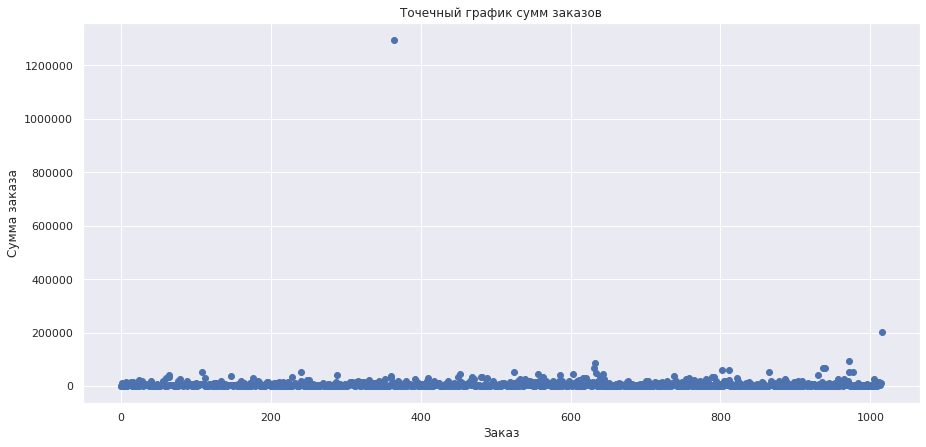

In [35]:
x_values = pd.Series(range(0,len(orders['transactionid'])))
plt.scatter(x_values,orders['revenue'])
plt.xlabel("Заказ")
plt.ylabel("Сумма заказа")
plt.title("Точечный график сумм заказов")

***В глаза бросаются два выброса***

**Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов**

In [36]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 26785.00
99 перцентиль: 53904.00


***Все, что за 95 перцентилем будем считать аномальным***

### 3.3. Посчитаем статистическую значимость различий в конверсии и различий в среднем чеке по группам на сырых и очищенных данных  <a name="33"></a>

**Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным**  
* Гипотеза H0: Конверсия группы A равна конверсии группы B  
* Гипотеза H1: Конверсия группы A НЕ равна конверсии группы B

***Сформируем таблицу с конверсиями по группам***

In [37]:
con = orders.groupby('group').agg({'transactionid':'count'}).join((visits.groupby('group').agg({'visitors':'sum'}))).reset_index()
con['conversion'] = con['transactionid'] / con['visitors']
con

,group,transactionid,visitors,conversion
0,A,468,18736,0.024979
1,B,548,18916,0.028970


***Попробуем отвергнуть H0***

In [38]:
alpha=0.05
purchases = np.array(con['transactionid'])
leads = np.array(con['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.016851380434703023
Отвергаем нулевую гипотезу


***Статистическая значимость есть***

***Рассчитаем относительное изменение конверсии группы В к А***

In [39]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(cumulativeDataA['visitors'].sum()\
                                                    - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(cumulativeDataB['visitors'].sum()\
                                                    - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.166


***Относительный выигрыш группы B примерно равен 16.6%***

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**
* Гипотеза H0: Средний чек группы A равен среднему чеку группы B
* Гипотеза H1: Средний чек группы A не равен среднему чеку группы B

***Посмотрим на средние чеки в группах***

In [40]:
orders.groupby('group').agg({'revenue':'mean'}).reset_index()

,group,revenue
0,A,7189.435897
1,B,9249.948905


***Попробуем отвергнуть H0***

In [41]:
alpha = 0.05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],alternative='two-sided')
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.8294908998149533
Не получилось отвергнуть H0: вывод о различии сделать нельзя


**Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным**
* Гипотеза H0: Конверсия группы A равна конверсии группы B  
* Гипотеза H1: Конверсия группы A НЕ равна конверсии группы B

***Сделаем датафрейм с чистыми данными***

In [42]:
orders_clean = orders.query('revenue < 26785 and visitorid not in @a_orders')

***Заного Сформируем таблицу с конверсиями по группам***

In [43]:
con = orders_clean.groupby('group').agg({'transactionid':'count'}).join((visits.groupby('group').agg({'visitors':'sum'}))).reset_index()
con['conversion'] = con['transactionid'] / con['visitors']
con

,group,transactionid,visitors,conversion
0,A,431,18736,0.023004
1,B,513,18916,0.027120


***Попробуем опровергнуть H0***

In [44]:
alpha=0.05
purchases = np.array(con['transactionid'])
leads = np.array(con['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.010641935071311392
Отвергаем нулевую гипотезу


***Статистическая значимость на "чистых данных" больше***

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным**
* Гипотеза H0: Средний чек группы A равен среднему чеку группы B
* Гипотеза H1: Средний чек группы A не равен среднему чеку группы B

***Посмотрим на средние чеки в группах***

In [45]:
orders_clean.groupby('group').agg({'revenue':'mean'}).reset_index()

,group,revenue
0,A,5135.962877
1,B,4855.192982


***Попробуем отвергнуть H0***

In [46]:
alpha = 0.05
results = st.mannwhitneyu(orders_clean[orders_clean['group']=='A']['revenue'], orders_clean[orders_clean['group']=='B']['revenue'], alternative='two-sided')
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.604787100416792
Не получилось отвергнуть H0: вывод о различии сделать нельзя


***Статистическая значимость на "чистых" данных не обнаружена***

***Рассчитаем относительное изменение среднего чека группы В к А***

In [47]:
orders_clean[orders_clean['group']=='B']['revenue'].mean()/orders_clean[orders_clean['group']=='A']['revenue'].mean()-1

-0.05466743068368429

***Средний чек группы B незначительно ниже среднего чека группы A***

### Вывод <a name="34"></a>

* По конверсии между группами A и B (как по сырым данным, так и по очищенным) есть статистически значимые различия;
* По среднему чеку между группами A и B (как по сырым данным, так и по очищенным) нет статистически значимых различий.

# Вывод <a name="4"></a>

Данный тест можно остановить и считать успешно проведенным. Конверсия из пользователя в покупателя у группы B статистически значимо выше, чем у группы A. При этом средний чек между группами не отличается.

Помимо этого, в процессе работы с данными было выяснено, что некоторые пользователи от сессии к сессии могли видеть как одну версию сайта, так и другую, что нарушает один из основных принцип работы A/B-теста - один пользователь видит только одну версию на всём протяжении теста.
В связи с этим, нам необходимо проверить корректность отработки метода показа пользователям одной или другой версии сайта и поправить его, чтобы одному и тому же пользователю показывалась только та версия сайта, которую он увидел при первом визите.